<H1> ARIMA forecasting of Tesla Stock Performance

<H2> 1.Introduction to the theme and motivation

127 000 new investors have descended upon the Oslo Stock Exchange, after the corona pandemic first appeared in Norway in March 2020. Most of those investors have never experienced a decline in their stock investments (e24.no). It is therefore essential to do analysis on stock performance in today's financial market situation, because it allows investors to make informed decisions about their investment. By analyzing the performance of a stock, investors can determine its potential for growth, identify potential risks and opportunities, and evaluate the companies financial health. This information can help investors make informed decisions about when to buy or sell a stock, and can also help them diversify their portfolios to minimize risk and maximize returns on investments. In today's volatile financial markets, this kind of analyses is essential for anyone looking to invest in stocks. 


For this project, I decided to conduct an exploratory study on the Tesla Stock. This was because it has undergone an unusual development and has exceeded many other investments in terms of return. Tesla is not your normal ordinary carmaker, and is not an ordinary technology company. Some of the best features of both worlds are combined in Tesla. We will be taking a deepdive into the ARIMA world, the main components of such models and how it could be used to forecast the logarithmic return for the Tesla Stock.

<H3> 1.2 Variables

I restricted my investigation to the period from January 1, 2015, to the present. The primary driver of this is the perception of Tesla's growth rate beginning in the years 2014 and 2015. The Tesla stock price has increased significantly since this point; we'll look at it later. I will primarily use the “Yahoo Download” function in order to access live data to work with and analyze. The reason I did not use the "Pandas Datareader" is beacuse the API from Yahoo Finance is down.


First, a brief overview of the other chosen variable:

**Dow Jones Industrial Average**
- In my analysis it's the “benchmark” for the market and therefore the benchmark for Tesla. Its an index consisting of 30 large blue-chip companies trading on the New York Stock Exchange (NYSE) and NASDAQ (investopedia). It will sort of represent the economic situation in America, but not completely since it only consists of 30 large companies. The reason I have chosen this index and not the typical tech index NASDAQ nor the big S&P500, is because Tesla is listed on both of them. This would have caused a relatively high correlation, since the market cap of Tesla is weighted relatively high on NASDAQ and S&P500. Its variable in the data frame will be “DJI”. 

<H3> 1.3 Collecting the packages and data

Normally when you are trading in the financial market, you will look at the raw price or the spot price.On the other hand, when the purpose is for statistical analysis on stock, it's recommended to use the “Adjusted closing price”. Since this price will factor in anything that might affect the stock price after the market has closed, such as stock splits, dividends and right offering (investopedia adjc). This will be important when I will examine the historical yield for the different assets. 

In [184]:
#All the neccessary packages

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as spt
import pandas_datareader as pdr
import statsmodels as sms
import statsmodels.formula.api as smf
import seaborn as sns
import statsmodels.api as sm
import pandas_datareader.data as web
from datetime import datetime
import math
import yfinance as yf
import random as rd
#For configuring plotting (standard)

from cycler import cycler

plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rcParams["axes.labelsize"]= 12
plt.rcParams["figure.facecolor"] = "#f2f2f2"
#plt.rcParams['figure.savefig.dpi'] = 100
plt.rcParams['savefig.edgecolor'] = "#f2f2f2"
plt.rcParams['savefig.facecolor'] ="#f2f2f2"
plt.rcParams["figure.figsize"] = [16,10]
plt.rcParams['savefig.bbox'] = "tight"
plt.rcParams['font.size'] = 14
greens = ['#66c2a4','#41ae76','#238b45','#006d2c','#00441b']
multi =['#66c2a4','#1f78b4','#a6cee3','#b2df8a','#33a02c','#fb9a99','#e31a1c','#fdbf6f']
plt.rcParams["axes.prop_cycle"] = cycler(color=multi)

#To make our plots nicer
sns.set(style="darkgrid",context="talk", palette="Dark2")

In [185]:
#Setting the start and end date
start="2015-01-01"
end="2023-06-07"

#Selecting the necessary tickers, for each stock/index
ticker=["TSLA","^DJI"]

#Exctracting the data from the ticker-list utilizing Yahoo-finance API
df=yf.download(ticker, start, end)

#Rename the main column we need
df.rename(columns={"Adj Close": "AdjC"}, inplace=True)

#Creating the final dataframe, with only the adjusting closing price
df=df["AdjC"]

#Calling on the dataframe in order to see how it looks, head() returns the five first rows
df.head()

[*********************100%***********************]  2 of 2 completed


,TSLA,^DJI
Date,,
2015-01-02,14.620667,17832.990234
2015-01-05,14.006000,17501.650391
2015-01-06,14.085333,17371.640625
2015-01-07,14.063333,17584.519531
2015-01-08,14.041333,17907.869141


In [186]:
#In order to not confuse the statistical models, we need to rename the columns again
df.rename(columns={"TSLA":"T_AdjC","^DJI":"DJI_AdjC"}, inplace=True)

<H3> 1.4 Transforming into Logarithmic Values

There is a problem with the arithmetic return, this can't be used to much else than just visualize the volatility. An example; if you have invested 100 dollar in Tesla day 1, then it went up to 150 dollar day 2. Suddenly on day 3, it went down back to 100 dollar. Arithmetic average return suggests that you gained an average return of 8.33%.
- AritReturn: $ \frac{[(\frac{150-100)}{100})+(\frac{(100-150)}{150})]} {2} = 0.0833 $


In reality with Log-values, you did not lose any of your money on the stock in this period, and had an average return of 0%:
- LogReturn: $\frac{[ln(150)-ln(100) + ln(100)-ln(150)]}{2} = 0$


This explains the reason to use log values, the log-returns take into account both the magnitude and signs of the return. This will be useful for both interpreting our three different ARIMA models.
I shall only utilize the stock and index values based on natural logarithmic from this point forward.


Easiest way to create and work with Log-values is to reset our Index from the original DataFrame, and create new columns in this dataframe which are the Log-values for our variables, as shown below:

In [187]:
#Reset the index, while creating our new dataframe
df=df.reset_index()
dfLog=pd.DataFrame(df["Date"])

#We use the built in Log from the Numpy Libary while take the difference between the observations in order to interpret them as returns
dfLog["T_Log"]=np.log(df["T_AdjC"]).diff()
dfLog["DJI_Log"]=np.log(df["DJI_AdjC"]).diff()

#We set the Index back again as the Date while drop the rows which contains NaN
dfLog=dfLog.set_index("Date").dropna()
dfLog

,T_Log,DJI_Log
Date,,
2015-01-05,-0.042950,-0.018755
2015-01-06,0.005648,-0.007456
2015-01-07,-0.001563,0.012180
2015-01-08,-0.001566,0.018221
2015-01-09,-0.018981,-0.009567
...,...,...
2023-05-31,0.013676,-0.004079
2023-06-01,0.017451,0.004648
2023-06-02,0.030608,0.020987


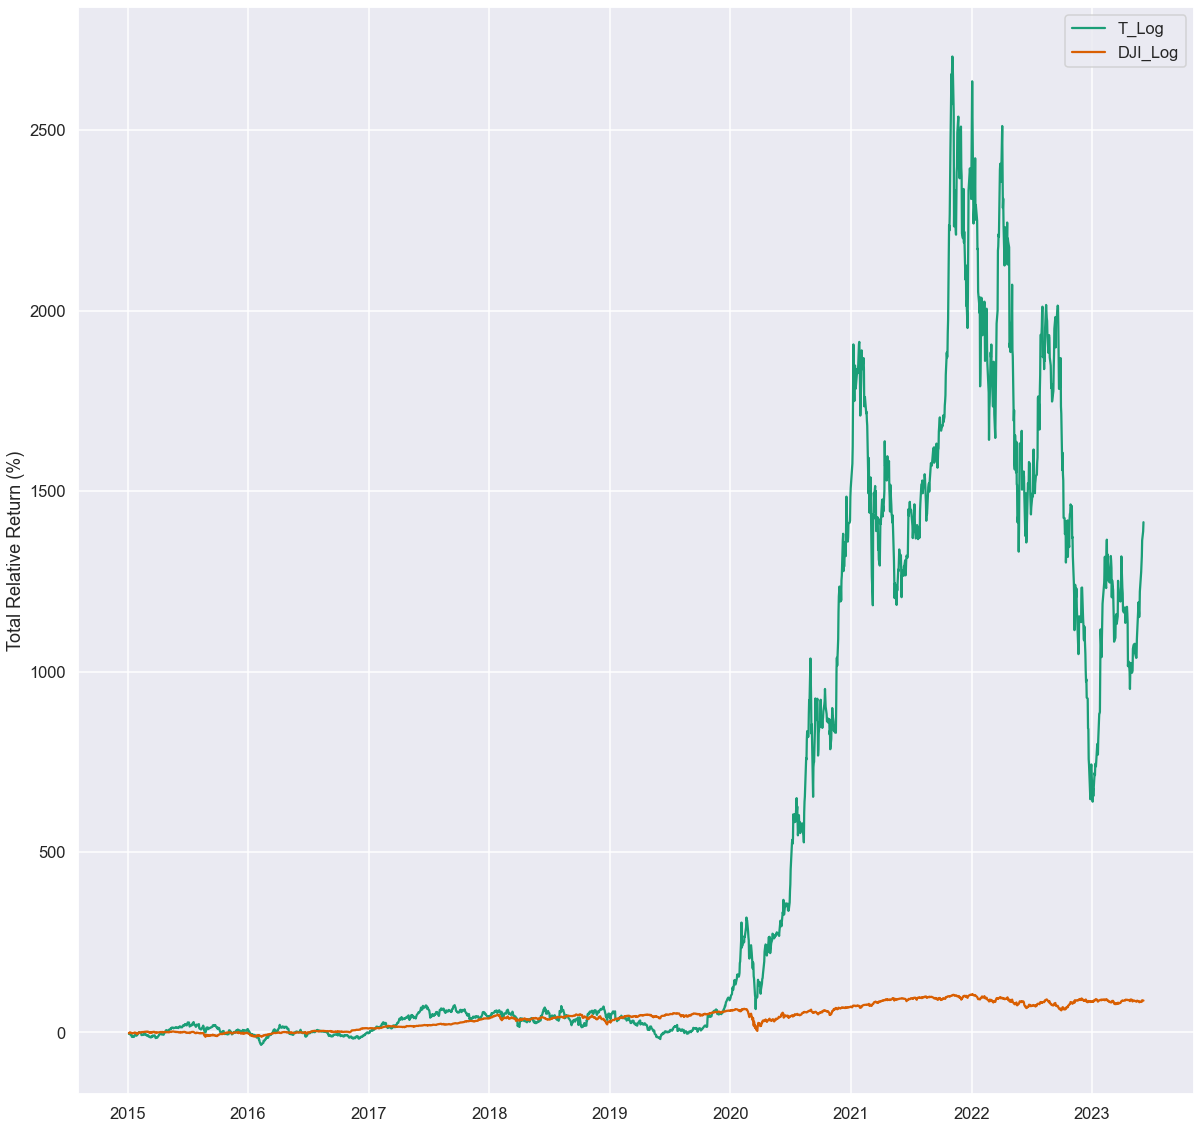

In [188]:
#Plot the total Relative sum of returns
fig, (ax1)=plt.subplots(1,1, figsize=(20,20))

for i in dfLog:
    ax1.plot(dfLog.index, 100*(np.exp(dfLog[i].cumsum())-1),label=str(i))

ax1.set_ylabel("Total Relative Return (%)")
ax1.legend(loc="best")
ax1.grid(True)

As we can see from the plot, it has been an remarkable relative return for the whole period in the Tesla Stock compared to the Dow Jones Index. One thing we can notice is that the volatility in Tesla is significantly much higher. 


Next I would like to introduce the three different ARIMA models.

<H1>2. ARIMA Model(s)

<H2>2.1 Introduction

The different ARIMA models provide an approach to forecasting of time series, and the models purpose is to describe the autocorrelation in the data. There is two main components it is important to understand when working with time series data, the concept of *stationarity* and technique of *differencing* time series. 

**Stationarity**
A stationary time series is one whose statistical properties do not depend on the time at which the series is observed. Taking into account that we work with a stock, then the logarithmic stock returns should constantly oscillate around zero if the efficient market hypothesis is correct. A trend would develop if investors were able to forecast future returns using historical returns. Therefore if the investors take advantage of this trend, it will soon cease to exist. This supports the notion that the extra logarithmic return would always be spread around zero, regardless of when it is observed. This is something we will check visually and using the ADF test on our data.


**Differencing**
The daily stock price development for Tesla is non-stationary, but the daily changes, in our case the return, is one way to transform non-stationary data into stationary. This procedure is *differencing*, as the name presents, we take the differences between the consecutive observations. This technique can help stabilising the mean of a time series by removing changes in the level of a time series, and therefore eliminating (or reducing) trends and seasonality in the data. We will utilize the *seasonal_decompose* package from the Statsmodels in order to check the seasonality. 


A Non-Seasonal ARIMA(p,d,q) model consist mainly of:
- AutoRegression (AR): This reflects its correlation with its past values. Here the "p" is the order of the Auto Regression
- Integrated (I): This reflects its number of differences by past value. "d" is the order 
- Moving Average (MA): This is the correlation between its past error. Here the "q" is order of the Moving Average.

The value of "d" has an effect on the prediction intervals. A higher value of "d", the more rapidly the prediction intervals increase in size. For "d=0", the long-term forecast standard deviation will go got the standard devation for the historical data. As a result, the prediction interals will be essentially the same.
There are two different ways to determine the value of (p,d,q):
1. *Lollipop plots*: We could use the ACF plot for determine "d" and PACF plot for the "p" value. This is an method which use the traditional confidence interval to determine the values
2. *PMDArima library* and the "auto_arima" package, which automatically determine the order for ARIMA. This is the one we will use, and explain later.

The mathematical notation for Non-Seasonal ARIMA model is:
- $y'_{t}=c +\phi_{1}y'_{t-1}+...+\phi_{p}y'_{t-1}+\theta_{1}\epsilon_{t-1}+...\theta_{q}\epsilon_{t-q}+\epsilon_{t}$
- Where $y'_{t}$ is the differenced series, and the dependent we want to predict and forecast. The predictors on the right hand side includes both the lagged values of $y_{t}$, the lagged errors $\theta_{q}\epsilon_{t-q}$ and the white noise $\epsilon_{t}$ with an distribution of mean 0 and variance 1.

The constant "c" has an important effect on the long-term forecasts obtained from these models:
- If "c"= 0, and "d"= 0, the long-term forecasts will go to zero
- If "c"= 0, and "d"= 1, the long-term forecasts will go to a non-zero constant
- If "c"= 0, and "d"= 2, the long-term forecasts will follow a straight line
- If "c"!= 0, and "d"= 0, the long-term forecasts will go to the mean of the data
- If "c"!= 0, and "d"= 1, the long-term forecasts will follow a straight line
- If "c"!= 0, and "d"= 2, the long-term forecasts will follow a quadratic trend. (This is not recommended)

As presented, AIRMA models are complex but easy to use for forecasting, and the order of the different elements (p,d,q) is essential to get right.


 
Next step would be to download all our necessary packages:

In [189]:
#Extract necessary packages for ARIMA
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.seasonal import STL
from pmdarima.arima.utils import ndiffs
from pmdarima import auto_arima
from statsmodels.tsa.statespace.sarimax import SARIMAX

#For Stationarity and transforming, ACF and PACF
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.stattools import acf, pacf

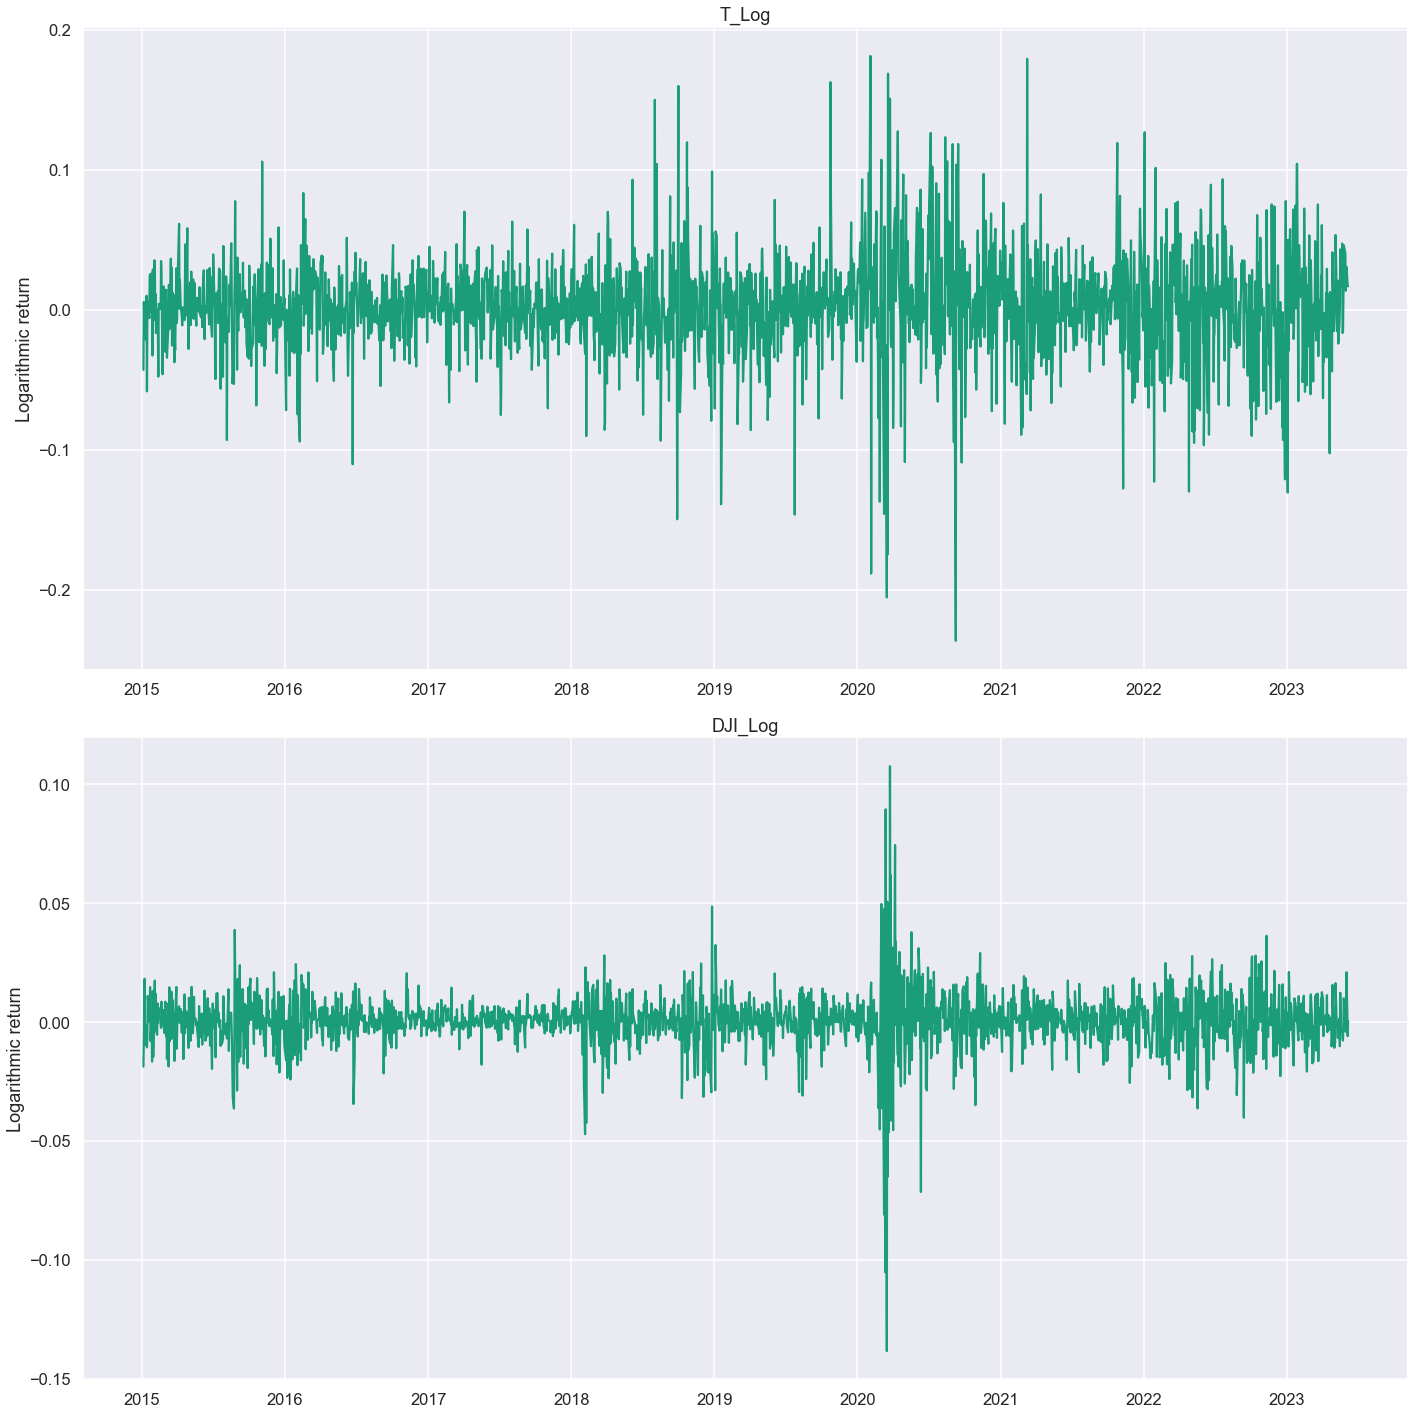

In [190]:
#We plot the Logarithmic return to see the volatility
fig,ax=plt.subplots(2, figsize=(20,20))
for i, col in enumerate(dfLog.columns):
    ax[i%2].plot(dfLog[col])
    ax[i%2].set_title(col)
    ax[i%2].set_ylabel("Logarithmic return")

#In order to automatically adjust the spacing between the subplots
fig.tight_layout()

plt.show()

As we can see from the plots, both of the investment assets (Tesla Stock and DJI Index) has had a period with high volatility and rapidly changing returns. Overall, both of the logarithmic returns fluctate around a mean of zero.

<H2>2.2 Augmented Dicker Fuller Test (ADF) / Unit Root Test

One of the most common method to test whether a data is non-stationary is to perform a "Unit Root" Test, and the one we will perform is the most known of them, the "Augmented Dicker Fuller" Test.

**Unit Root Test**


A "Unit Root" is a condition in the time series where the root of the characteristic equation is equal to 1, we can formulate a Unit Root in a mathematical notation:
- $Y_{t}=\alpha Y_{t-1}+BX_{e}+\epsilon$
- Where $Y_{t}$is the value of the time series at time "t", and $X_e$ is an exogenous variable
- If the value of $\alpha$ is 1, then the time series is said to be non-stationary. Reason for this is because a value of 1 indicates that the current value of the series is perfectly linear correlated with the previous value, and this correlation extends back infinitely. The result of this is making it impossible to distinguish between trend and random fluctations in our data. Hence why we can use the "differencing" technique in order to make it (very often) a stationary data.

**Augmented Dickey Fuller Test**


This test is based on the **Dickey Fuller** test, and the main difference between them is that the ADF test accounts for higher-order autoregressive processess and other variables that may affect the time series.
We can formulate our hypothesis based on this:

- *Null Hypothesis*: Data is not stationary
- *Alternative Hypothesis*: Data is stationary



**Test for stationarity**



Setting the "Autolag" parameter to "AIC" is generally considered as a good approach since it selects the optimal number of lags while accounting for the trade-off between model complexity and goodness of fit.

In [191]:
for i,column in enumerate(dfLog.columns):
    test=adfuller(dfLog[column],autolag="aic")
    print(f"Asset: {column}")
    print(f"The ADF Statistics:{test[0]}")
    print(f"The p-value:{test[1]}\n")
    for key,value in test[4].items():
            print(f"Asset: {column}")
            print("Critical Values: ")
            print(f"{key},{value} \n")

Asset: T_Log
The ADF Statistics:-10.358161269695804
The p-value:2.4356972988265063e-18

Asset: T_Log
Critical Values: 
1%,-3.43346628154387 

Asset: T_Log
Critical Values: 
5%,-2.8629166417427734 

Asset: T_Log
Critical Values: 
10%,-2.5675028591063254 

Asset: DJI_Log
The ADF Statistics:-14.352713311210257
The p-value:1.0153710939286005e-26

Asset: DJI_Log
Critical Values: 
1%,-3.433452973124137 

Asset: DJI_Log
Critical Values: 
5%,-2.862910765700749 

Asset: DJI_Log
Critical Values: 
10%,-2.5674997304642755 



We can interpret the long list of printed values from the ADF-test, and what we are looking for is as follows:
- The ADF Statistic value is less than the three different critical values, this is basically a T-test on the $\alpha$ parameter
- The P-value is less than our critical value of 0.05, this indicates a significance level of 5% and our variables would be statistically significant if this fulfills. 

Based on the long printed list, both the T_log and DJI_log fulfills the ADF test, and we can reject our null hypothesis, and conclude that our data is stationary.

Luckily we could also use a built-in function from the "pmdarima-library", named "ndiffs" as shown below:

In [192]:
for i,column in enumerate(dfLog.columns):
    test=ndiffs(dfLog[column],test="adf")
    print(f"Asset: {column}")
    print(f"Number of differencing to make our data stationary: {test} \n")

Asset: T_Log
Number of differencing to make our data stationary: 0 

Asset: DJI_Log
Number of differencing to make our data stationary: 0 



Therefore, we can say 100% sure that our time series data we are working on, is stationary. Now we can move on into check for seasonality.

<H2> 2.3 (S)ARIMA on Tesla Stock

We will now start applying the following steps for the ARIMA model on the Tesla Stock:
- Extracting only the log-returns for the Tesla Stock
- Check for Seasonality, to see if we are actually working with a SARIMA (Seasonal ARIMA)
- Split the Dataset in Training and Test set (the usual 80% training and 20% test)
- Run the Auto_ARIMA to determine the order and potentially the seasonal order
- Plot the different results for the forecasting and see if there are any changes we need to perform


So lets begin with the first one, extracting only the Tesla data from the dfLog dataframe. After working on this project for a while, because of the structure of the dataset (irregular time intervals) we need to resample the data to a regular frequency. The closest to the daily log-returns, is the weekly, as shown below:

In [193]:
tsla=dfLog["T_Log"].resample("W").sum()
Tsla=pd.DataFrame(tsla)
Tsla

,T_Log
Date,
2015-01-11,-0.059411
2015-01-18,-0.068022
2015-01-25,0.041694
2015-02-01,0.011411
2015-02-08,0.065398
...,...
2023-05-14,-0.012306
2023-05-21,0.069889
2023-05-28,0.069836


**Check for seasonality**

As explained above, when working with ARIMA-modeling its quite important to check for seasonality in the data, if there are any repeating short-term cycles. Roughly there are two ways to analyze stationarity of a time series, either *additive* model or the *multiplicative*. I will be using the *additive* model, since the *multiplicative* model has an increasing/decreasing amplitude and/or frequency over time, which I do not have. 

Therefore we will utilize the seasonal_decompose package from sm.tsa, as shown below:

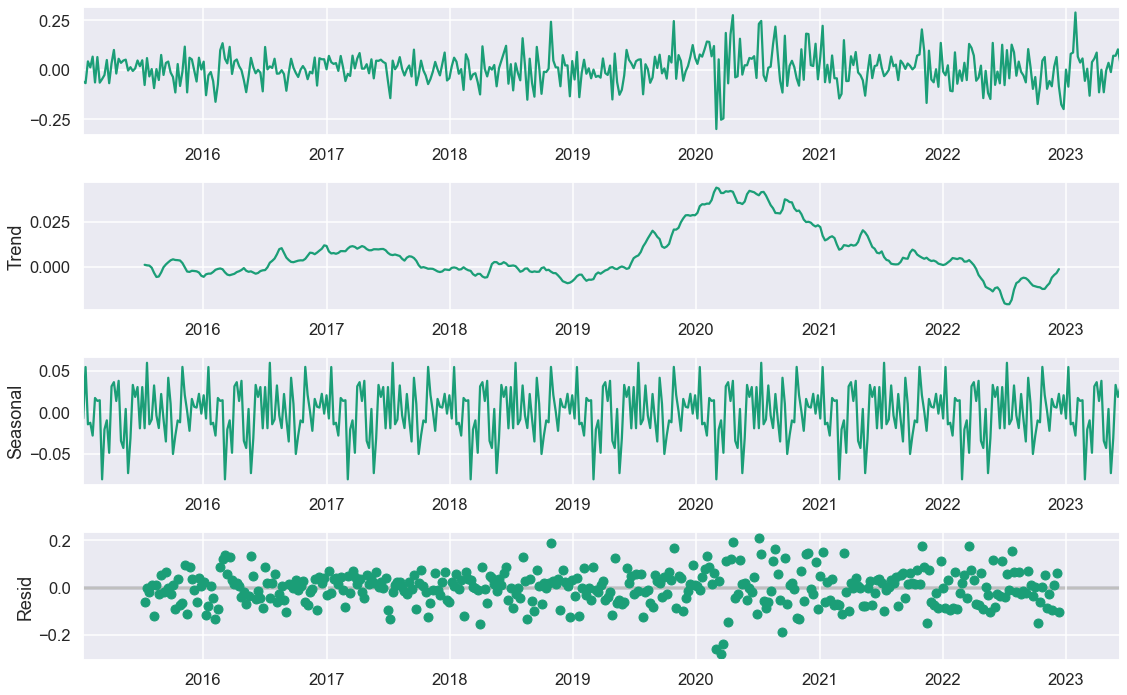

In [194]:
decomposition=sm.tsa.seasonal_decompose(Tsla, model="additive")
fig=decomposition.plot()
plt.show()

Lets shortly interpret the result, and comment on the plots:
- Trend Plot: The trend plot looks like what we have pointed out earlier, its stock price increased during the pandemic and decreased rapidly after
- Seasonal: There are repeating short-term cycles in the series. This indicates we are working with SARIMA
- Residual plot: As we can see, the residuals are spread around zero, with a lot of random variation in the series. Especially in the period under pandemic.



Next thing in the assignment is to split up my time series into training and test sets. The reason behind this is to apply SARIMA for my training set, and compare these results up to my values in the test set.

In [195]:
num_rows=len(Tsla)
train=int(num_rows*0.8)
test=int(num_rows*0.2)
train_df=Tsla[:train]
test_df=Tsla[test:]

**Using the Auto_arima to calculate the order and the seasonal order**

In [196]:
auto_arima(train_df, exogenous=None,
          start_P=0,
          test="adf",
          d=None,
          seasonal=True,
          D=1,
          stationary=True,
          m=52,    #M=52 for number of trading weeks
          trace=True, error_action="ignore", suppres_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,1)[52] intercept   : AIC=-805.784, Time=6.99 sec
 ARIMA(0,0,0)(0,0,0)[52] intercept   : AIC=-808.561, Time=0.07 sec
 ARIMA(1,0,0)(1,0,0)[52] intercept   : AIC=-806.757, Time=1.76 sec
 ARIMA(0,0,1)(0,0,1)[52] intercept   : AIC=-806.765, Time=2.67 sec
 ARIMA(0,0,0)(0,0,0)[52]             : AIC=-806.558, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[52] intercept   : AIC=-808.672, Time=1.55 sec
 ARIMA(0,0,0)(2,0,0)[52] intercept   : AIC=-806.680, Time=7.38 sec
 ARIMA(0,0,0)(1,0,1)[52] intercept   : AIC=-806.608, Time=1.18 sec
 ARIMA(0,0,0)(0,0,1)[52] intercept   : AIC=-808.684, Time=0.93 sec
 ARIMA(0,0,0)(0,0,2)[52] intercept   : AIC=-806.686, Time=5.82 sec
 ARIMA(0,0,0)(1,0,2)[52] intercept   : AIC=-804.685, Time=9.69 sec
 ARIMA(1,0,0)(0,0,1)[52] intercept   : AIC=-806.768, Time=2.23 sec
 ARIMA(1,0,1)(0,0,1)[52] intercept   : AIC=-804.767, Time=2.51 sec
 ARIMA(0,0,0)(0,0,1)[52]             : AIC=-807.233, Time=0.78 sec

Best model:  ARIMA

ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 1, 52),
      suppress_warnings=True)

**Comment**:


Now that we have chosen the seasonal order of our SARIMA, the thing is to fit the model based on this. I tried and tested the standard SARIMA model, however it did not produce the desired outcome. Especially for forecasting and value prediction. My initial SARIMA model did not appear to be able to capture the distinctive frequency of the logarithmic return on the Tesla stock. As a result, I determined that by setting "exogen=none" in the SARIMAX, the best model was produced. This particular model's AIC and BIC values were also the lowest, which validates the rationale for choosing it:

In [197]:
#Fit the SARIMAX model on my train_set, choosing both the order and the seasonal order, and setting the Exogen as "none"
SARIMAX=sm.tsa.SARIMAX(Tsla, exog=None, order=(0,0,0), seasonal_order=(0,0,1,52)).fit()
SARIMAX.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 SARIMAX Results                                  
==================================================================================
Dep. Variable:                      T_Log   No. Observations:                  440
Model:             SARIMAX(0, 0, [1], 52)   Log Likelihood                 489.566
Date:                    Wed, 07 Jun 2023   AIC                           -975.133
Time:                            20:11:15   BIC                           -966.959
Sample:                        01-11-2015   HQIC                          -971.908
                             - 06-11-2023                                         
Covariance Type:                      opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ma.S.L52       0.0738      0.047      1.567      0.117      -0.019       0.166
sigma2         0.0063      0.000     19.181      0.000       0.006       0.007
===================================================================================
Ljung-Box (L1) (Q):                   0.73   Jarque-Bera (JB):                33.13
Prob(Q):                              0.39   Prob(JB):                         0.00
Heteroskedasticity (H):               2.49   Skew:                             0.11
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.32
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

In [198]:
#Using my model to forecast the values
fore=SARIMAX.get_forecast(steps=52).summary_frame()
fore

T_Log,mean,mean_se,mean_ci_lower,mean_ci_upper
2023-06-18,-0.005183,0.079502,-0.161004,0.150638
2023-06-25,0.008829,0.079502,-0.146992,0.164650
2023-07-02,-0.005727,0.079502,-0.161548,0.150094
2023-07-09,0.007542,0.079502,-0.148279,0.163363
2023-07-16,-0.003125,0.079502,-0.158946,0.152696
2023-07-23,0.009275,0.079502,-0.146546,0.165096
2023-07-30,0.006108,0.079502,-0.149713,0.161929
2023-08-06,-0.002353,0.079502,-0.158174,0.153468
2023-08-13,0.002892,0.079502,-0.152929,0.158713
2023-08-20,-0.000456,0.079502,-0.156277,0.155365


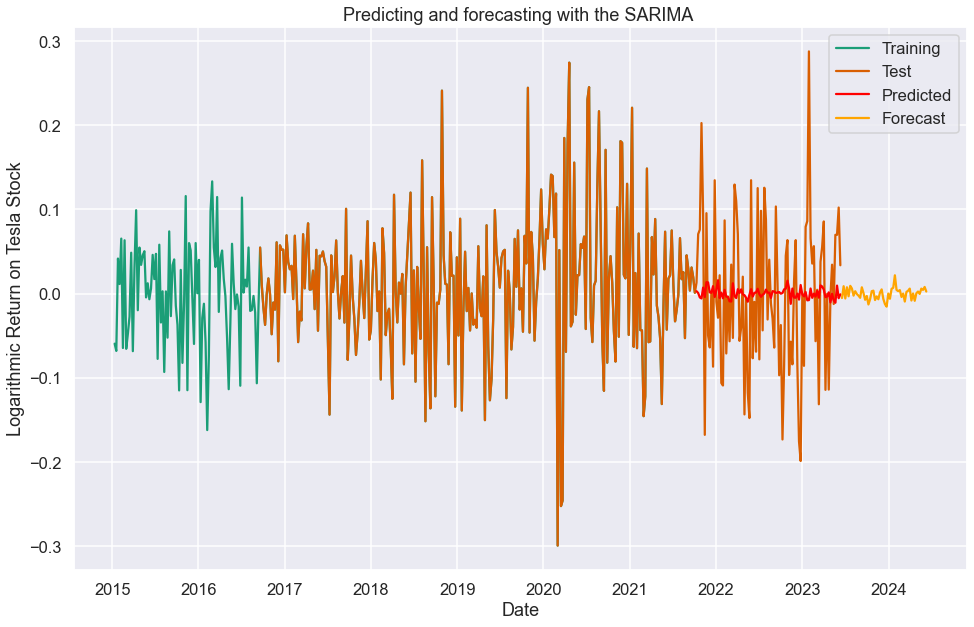

In [199]:
#Using my model to predict the values we already know
pred=SARIMAX.predict(start=len(train_df),end=(len(Tsla)-1))

fig,ax=plt.subplots()
ax.plot(train_df, label="Training")
ax.plot(test_df, label="Test")
ax.plot(pred, color="red", label="Predicted")
ax.plot(fore["mean"], color="orange", label="Forecast")
ax.legend(loc="upper right")


ax.set(title="Predicting and forecasting with the SARIMA ",
      ylabel="Logarithmic Return on Tesla Stock",
      xlabel="Date")

plt.grid(True)
plt.show()

**Comment:**


Our plot demonstrates that the SARIMA model was successful in simulating some of the volatility in both the prediction and the forecasting. However, its volatility significantly deviates from its genuine value. This indicates that this volatility is influenced by one or more variables that our model is not able to catch. This may suggest that trying to estimate or forecast the logarithmic return on the Tesla stock using conventional financial instruments and regular statistical analysis is futile. 



Let's try including a real exogenous variable then, we want to see how the DJI_Log affect the forecasting of the T_Log.

<H2> 2.4 SARIMAX model and forecasting

**Short Introduction to SARIMAX**
SARIMAX (Seasonal Auto-Regressive Integrated Moving Average with eXgenous factors) is as the name suggest, a ARIMA model with an exogenous explanatory variable included. In our case, we would like to implement the DJI_Log as the exogenous variable in order to see how the SARIMAX model behaves.


We know from before that the whole dfLog dataframe is stationary, so now we will resample both the T_Log and DJI_Log into a weekly sum-values. This code below is quite messy, but the reason behind this is we need the "Date" as a column and as the index

In [200]:
#Extracting necessary data
dfSARIMAX=dfLog [["T_Log","DJI_Log"]].resample("W").sum()

#Resetting the index in order to make it as a column
dfSARIMAX=dfSARIMAX.reset_index().copy()

#Making a "copy" of the original date
dfSARIMAX["date"]=pd.to_datetime(dfSARIMAX["Date"])

#Setting the original Date as the index
dfSARIMAX=dfSARIMAX.set_index("Date")

#Now we will end up with the "Date" as the index and "date" as its own column
dfSARIMAX.tail()

,T_Log,DJI_Log,date
Date,,,
2023-05-14,-0.012306,-0.011161,2023-05-14
2023-05-21,0.069889,0.003777,2023-05-21
2023-05-28,0.069836,-0.010021,2023-05-28
2023-06-04,0.102265,0.020026,2023-06-04
2023-06-11,0.033729,-0.005628,2023-06-11


In [201]:
auto_arima(dfSARIMAX["T_Log"],exogenous=dfSARIMAX["DJI_Log"],
           test="adf",
           d=None,
           seasonal=True,
           D=1,
           stationary=True,
           m=12,  #m=12 for number of trading month
           trace=True, error_action="ignore", suppress_warnings=True, stepwise=True)

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(1,0,1)[12] intercept   : AIC=-970.409, Time=1.23 sec
 ARIMA(0,0,0)(0,0,0)[12] intercept   : AIC=-975.846, Time=0.09 sec
 ARIMA(1,0,0)(1,0,0)[12] intercept   : AIC=-972.479, Time=0.26 sec
 ARIMA(0,0,1)(0,0,1)[12] intercept   : AIC=-972.418, Time=0.29 sec
 ARIMA(0,0,0)(0,0,0)[12]             : AIC=-975.197, Time=0.05 sec
 ARIMA(0,0,0)(1,0,0)[12] intercept   : AIC=-973.850, Time=0.16 sec
 ARIMA(0,0,0)(0,0,1)[12] intercept   : AIC=-973.851, Time=0.15 sec
 ARIMA(0,0,0)(1,0,1)[12] intercept   : AIC=-972.923, Time=0.61 sec
 ARIMA(1,0,0)(0,0,0)[12] intercept   : AIC=-974.462, Time=0.09 sec
 ARIMA(0,0,1)(0,0,0)[12] intercept   : AIC=-974.400, Time=0.22 sec
 ARIMA(1,0,1)(0,0,0)[12] intercept   : AIC=-972.152, Time=0.60 sec

Best model:  ARIMA(0,0,0)(0,0,0)[12] intercept
Total fit time: 3.757 seconds


ARIMA(order=(0, 0, 0), scoring_args={}, seasonal_order=(0, 0, 0, 12),
      suppress_warnings=True)

In [202]:
#Setting our model with the order and seasonal order
SARIMAX2=sm.tsa.SARIMAX(endog=dfSARIMAX.T_Log,
                        exog=dfSARIMAX.DJI_Log, 
                        order=(0,0,0), seasonal_order=(0,0,0,12)).fit()
SARIMAX2.summary()

C:\Users\henri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)
C:\Users\henri\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency W-SUN will be used.
  self._init_dates(dates, freq)


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                  T_Log   No. Observations:                  440
Model:                        SARIMAX   Log Likelihood                 546.238
Date:                Wed, 07 Jun 2023   AIC                          -1088.477
Time:                        20:11:22   BIC                          -1080.303
Sample:                    01-11-2015   HQIC                         -1085.252
                         - 06-11-2023                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
DJI_Log        1.5234      0.144     10.569      0.000       1.241       1.806
sigma2         0.0049      0.000     20.595      0.000       0.004       0.005
===================================================================================
Ljung-Box (L1) (Q):                   2.55   Jarque-Bera (JB):                69.17
Prob(Q):                              0.11   Prob(JB):                         0.00
Heteroskedasticity (H):               2.48   Skew:                             0.35
Prob(H) (two-sided):                  0.00   Kurtosis:                         4.81
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

**Comment**


In order to confirm that our SARIMAX model is performing, we can run a diagnostic on it, as shown below:

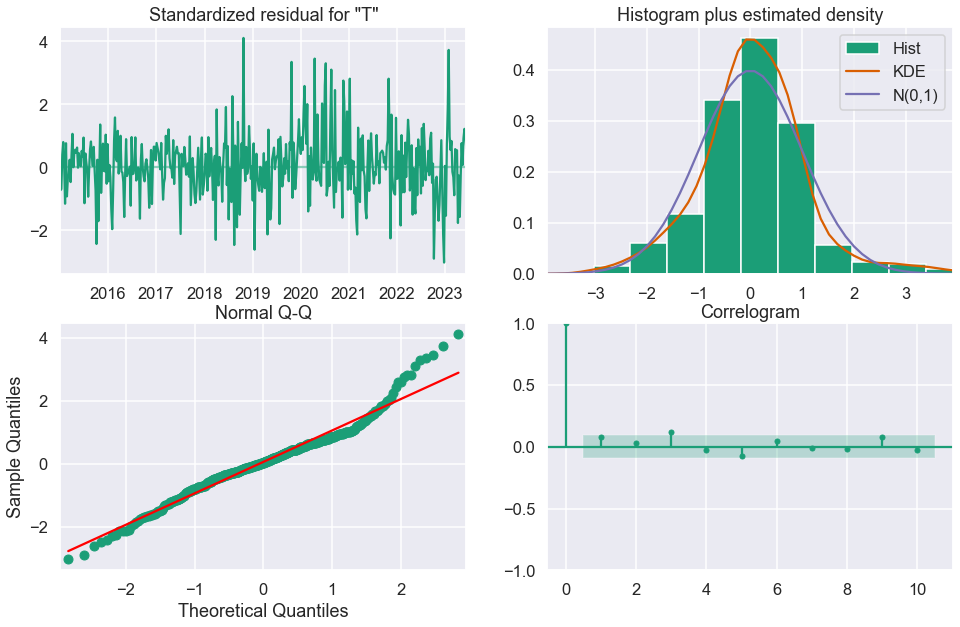

In [203]:
#Extracting the diagnostics plots
SARIMAX2.plot_diagnostics()
plt.show()

**Comment**


We can intepret these plots:
- *Standardized residuals plot*: In the top left corner, the plot shows the "one-step-ahead" standardized residuals. The criteria here is that the residuals should not show any obvious patterns. In our case, it fulfills this requirement. 


- *Historgam plus estimated density*: In the top right corner, the plot shows the distribution of our residuals. The histogram is the measured distribution, the KDE (blue line) shows a smoothed version of the histogram, and the lastline N(0,1) shows the normal distribution. The criteria is that there should be little to no difference in these two lines. In our case, there are some small differences, which indicates that our model is doing well.  


- *Normal Q-Q plot*: This plot compares the residuals to the normal distribution. Here the criteria is that the dots lie on along the red line, which in our case they do. And it's okay that some of the values do not at the end. 


- *Correlogram plot*: Down in the right corner is the ACF plot of the residuals. Here 95% of the correlations lags greater than zero should not be significant. As we can see by the plot, it's only one lollipop who is not significant. Therefore, our model is within this criteria. 



Overall, by the diagnostics of the SARIMAX model, it's working well. Therefore we can rely on its result and its credibility. 

<H3> 2.4.1 Forecasting with high and low scenarios

With our model in place, we can start forecasting. First, I had to perform some straightforward statistical analysis on the total value of our exogenous variable DJI_Log. The reason for this is I wanted to create a high scenario and a low scenario for the T_Log.

In [204]:
#Extract some simple statistics for the weekly,aggregated values for DJI_Log
dfSARIMAX.DJI_Log.describe()

count    440.000000
mean       0.001438
std        0.025107
min       -0.189978
25%       -0.008637
50%        0.002262
75%        0.013627
max        0.120840
Name: DJI_Log, dtype: float64

<H4> Creating the high and low scenario values

In [205]:
#Chose to utilize the random.uniform in order to replicate historical "jumps"

#Random value from -0.001 up to 0.3, and 12 values
high_DJI=np.random.uniform(-0.001, 0.3, size= 52)

#Random value from -0.2 up to 0.15, and 12 values
low_DJI=np.random.uniform(-0.2,0.15, size=52)

In [206]:
#Calculating the forecasting high
forecast_high=SARIMAX2.get_forecast(exog=high_DJI, steps=52).summary_frame()
#Calculating the forecasting low
forecast_low=SARIMAX2.get_forecast(exog=low_DJI, steps=52).summary_frame()

In [207]:
#Selecting the starting Dates
forecast_high["Date"]=pd.date_range(start="2023-06-18",
                                   freq="W", periods=52)

forecast_low["Date"]=pd.date_range(start="2023-06-18",
                                   freq="W", periods=52)

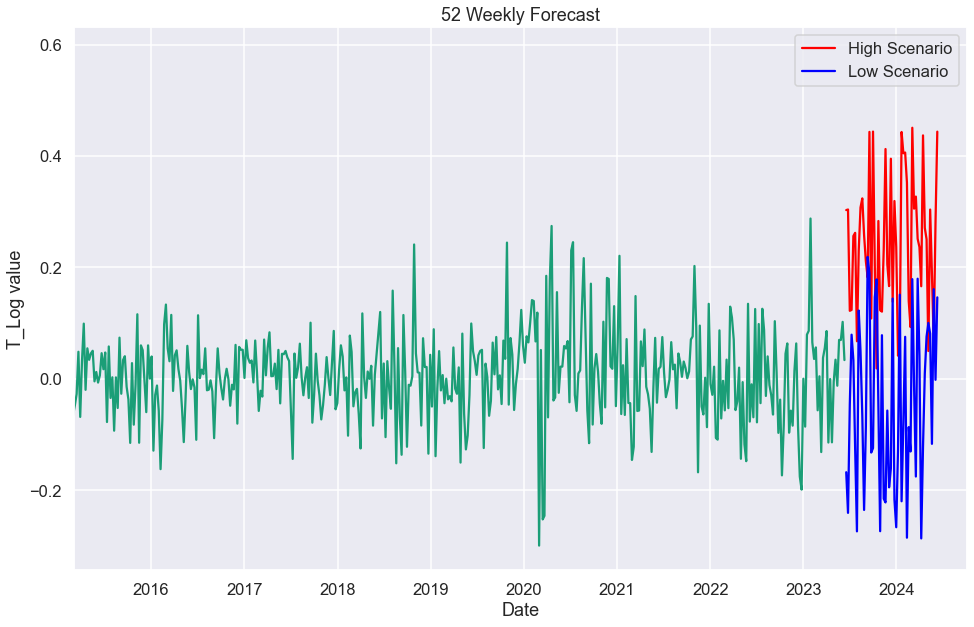

In [208]:
fig,ax=plt.subplots()
#High scenario
ax.plot(forecast_high["mean"], color="red", label="High Scenario")
ax.fill_between(forecast_high["mean_ci_lower"], 
                forecast_high["mean_ci_upper"])

#Low scenario
ax.plot(forecast_low["mean"], color="blue", label="Low Scenario")
ax.fill_between(forecast_low["mean_ci_lower"], 
                forecast_low["mean_ci_upper"])

#
ax.plot(dfSARIMAX.T_Log)
ax.legend(loc="upper right")

#Since there was some trouble with the DateTimeIndex, I had to chose some random values for the x_lim
ax.set_xlim(16500,20000)

ax.set(title="52 Weekly Forecast",
      ylabel="T_Log value",
      xlabel="Date")
plt.show()

*The forecasting values and the visualization will be different for each time we run the random value generator for the low and high scenario*. But overall compared to the normal SARIMA model, the main difference is the forecasting of the high and low scenarios. The model is able to, some what degree, capture the volatility that follows the Log-return for the Tesla stock. 

**Last comment**


Thanks for reading this ARIMA forecasting project, follow me on Github for more ! :D 